In [1]:
!pip -q install lightkurve astroquery numpy pandas matplotlib scikit-learn tqdm pyarrow fastparquet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 5.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 85.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 83.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframe

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, 
                                      Dropout, GlobalAveragePooling1D, BatchNormalization,
                                      Concatenate, MultiHeadAttention, LayerNormalization,
                                      Add, GlobalMaxPooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
import shap
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7,4)
np.random.seed(42)
os.makedirs("artifacts", exist_ok=True)

TAB_N_PER_CLASS = 200    

LC_TARGET_WINDOWS = 1200  

PER_TARGET_LIMIT = 3      

PHASE_HALF_WIDTH = 0.12  
LC_N_PER_CLASS = 400
MIN_POINTS = 60           
MAX_WIDTH = 0.25          
N_BINS = 200              

print("Setup complete.")

Setup complete.


In [11]:
save_dir = "artifacts"
os.makedirs(save_dir, exist_ok=True)

In [13]:
cols = (
    "kepid,kepoi_name,kepler_name,"
    "koi_disposition,koi_pdisposition,"
    "koi_period,koi_time0bk,koi_duration,koi_depth,koi_model_snr,"
    "koi_insol,koi_teq,"
    "koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec"
)

koi_tbl = NasaExoplanetArchive.query_criteria(
    table="Q1_Q17_DR25_KOI",
    select=cols,
    where="koi_disposition in ('CONFIRMED','CANDIDATE','FALSE POSITIVE') "
          "and koi_period > 0 and koi_time0bk is not null"
)

df = koi_tbl.to_pandas()

df = (df.sort_values(["kepid","koi_period"])
        .drop_duplicates(subset=["kepid"], keep="first")
        .reset_index(drop=True))

num_cols = ["koi_period","koi_time0bk","koi_duration","koi_depth",
            "koi_model_snr","koi_insol","koi_teq"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["habitable_zone"] = df["koi_insol"].apply(lambda x: 1 if 0.25 < x < 1.5 else 0)

print("\nNumber of planets in habitable zone:")
print(df["habitable_zone"].value_counts())

tabular_df = (df.groupby("koi_disposition", group_keys=False)
                .apply(lambda g: g.sample(min(TAB_N_PER_CLASS, len(g)), random_state=42))
                .reset_index(drop=True))

prior_df = (df.sort_values(["koi_disposition","koi_model_snr"], ascending=[True, False])
              .groupby("koi_disposition", group_keys=True)
              .head(LC_N_PER_CLASS)
              .reset_index(drop=True))


tabular_df.to_csv(f"{save_dir}/tabular_df.csv", index=False)
prior_df.to_csv(f"{save_dir}/prior_df.csv", index=False)

print("\nFinal dataset sizes:")
print("Tabular DF:", tabular_df["koi_disposition"].value_counts().to_dict())
print("Prior LC DF:", prior_df["koi_disposition"].value_counts().to_dict())

print("Files saved to:", save_dir)


Number of planets in habitable zone:
habitable_zone
0    6676
1     247
Name: count, dtype: int64

Final dataset sizes:
Tabular DF: {'CANDIDATE': 200, 'CONFIRMED': 200, 'FALSE POSITIVE': 200}
Prior LC DF: {'CANDIDATE': 400, 'CONFIRMED': 400, 'FALSE POSITIVE': 400}
Files saved to: /kaggle/working/artifacts


In [16]:
from lightkurve import KeplerQualityFlags as KQ

def download_kepler_lc(kepid, limit_per_target=PER_TARGET_LIMIT, quarter=None):
    """
    Download & stitch Kepler long-cadence PDCSAP light curves for a given KIC (kepid).
    Uses 'KIC {kepid}' to avoid TIC ambiguity.
    """
    target = f"KIC {int(kepid)}"
    srch = lk.search_lightcurve(
        target, mission="Kepler", author="Kepler",
        exptime="long", limit=limit_per_target, quarter=quarter
    )
    if len(srch) == 0:
        return None

    lc = srch.download_all().stitch()
    
    lc = (
        lc.remove_nans()
          .flatten(window_length=401)
          .normalize()
          .remove_outliers(sigma=7) 
    )
    return lc


def fold_and_slice(lc, period_days, epoch_bkjd,
                   phase_half_width=PHASE_HALF_WIDTH,
                   min_points=MIN_POINTS, max_width=MAX_WIDTH):
    folded = lc.fold(period_days, epoch_time=epoch_bkjd)
    ph = folded.phase.value
    fx = folded.flux.value

    width = float(phase_half_width)
    for _ in range(3):  # widen at most 3x
        mask = (ph > -width) & (ph < width)
        if mask.sum() >= min_points:
            return ph[mask], fx[mask]
        width = min(max_width, width * 1.5)
    return np.array([]), np.array([])


def to_fixed_bins(phase, flux, n_bins=N_BINS):
    if len(phase) == 0:
        return np.array([]), np.array([])
    order = np.argsort(phase)
    phase_sorted = phase[order]
    flux_sorted  = flux[order]
    grid = np.linspace(phase_sorted.min(), phase_sorted.max(), n_bins)
    flux_binned = np.interp(grid, phase_sorted, flux_sorted)
    return grid.astype(np.float32), flux_binned.astype(np.float32)


In [17]:
label_map = {"FALSE POSITIVE": 0, "CANDIDATE": 1, "CONFIRMED": 2}

X_lc_list, y_lc_list = [], []
lc_records = []
built = 0

for _, row in tqdm(prior_df.iterrows(), total=len(prior_df), desc="Building LC windows"):
    kepid = int(row["kepid"])
    disp  = str(row["koi_disposition"])

    per   = float(row["koi_period"]) if pd.notnull(row["koi_period"]) else np.nan
    epoch = float(row["koi_time0bk"]) if pd.notnull(row["koi_time0bk"]) else np.nan
    if not np.isfinite(per) or not np.isfinite(epoch):
        continue

    try:
        lc = download_kepler_lc(kepid, limit_per_target=PER_TARGET_LIMIT)
        if lc is None:
            continue

        ph, fx = fold_and_slice(lc, per, epoch,
                                phase_half_width=PHASE_HALF_WIDTH,
                                min_points=MIN_POINTS, max_width=MAX_WIDTH)
        if len(ph) == 0:
            continue

        grid, fx_bin = to_fixed_bins(ph, fx, n_bins=N_BINS)
        if len(fx_bin) == 0:
            continue

        X_lc_list.append(fx_bin)
        y_lc_list.append(label_map[disp])

        lc_records.append({
            "kepid": kepid,
            "label": disp,
            "y": label_map[disp],
            "koi_period": per,
            "koi_time0bk": epoch,
            "koi_duration": float(row.get("koi_duration", np.nan)),
            "koi_depth": float(row.get("koi_depth", np.nan)),
            "koi_model_snr": float(row.get("koi_model_snr", np.nan))
        })

        built += 1
        if built % 100 == 0:
            print(f"...built {built} windows")
        if built >= LC_TARGET_WINDOWS:
            break

    except Exception as e:
        pass

if built == 0:
    raise RuntimeError("No LC windows built. Relax filters or increase PER_TARGET_LIMIT / pool size.")

X_lc = np.vstack(X_lc_list)                 
y_lc = np.array(y_lc_list, dtype=np.int64) 
features_lc = pd.DataFrame.from_records(lc_records)

print("LC windows:", X_lc.shape, "labels:", y_lc.shape)
print(features_lc["label"].value_counts())

Building LC windows:   0%|          | 0/1200 [00:00<?, ?it/s]

1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be igno

...built 100 windows


1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be i

...built 200 windows


1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (43/4159) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (46/4538) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (37/4313) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored

...built 300 windows


1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ig

...built 400 windows


1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ig

...built 500 windows


1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ign

...built 600 windows


1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be

...built 700 windows


1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be igno

...built 800 windows


1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be i

...built 900 windows


1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be igno

LC windows: (988, 200) labels: (988,)
label
CONFIRMED         357
FALSE POSITIVE    321
CANDIDATE         310
Name: count, dtype: int64


In [20]:
koi_df = koi_tbl.to_pandas()

# One row per star (pick the shortest-period entry per KIC to avoid dupes)
koi_df = (koi_df.sort_values(["kepid","koi_period"])
                  .drop_duplicates(subset=["kepid"], keep="first")
                  .reset_index(drop=True))

sample_tab_df = (koi_df
    .groupby("koi_disposition", group_keys=False)
    .apply(lambda g: g.sample(min(TAB_N_PER_CLASS, len(g)), random_state=42))
    .reset_index(drop=True))

Tabular X: (600, 8) y: (600,)
koi_disposition
CANDIDATE         200
CONFIRMED         200
FALSE POSITIVE    200
Name: count, dtype: int64


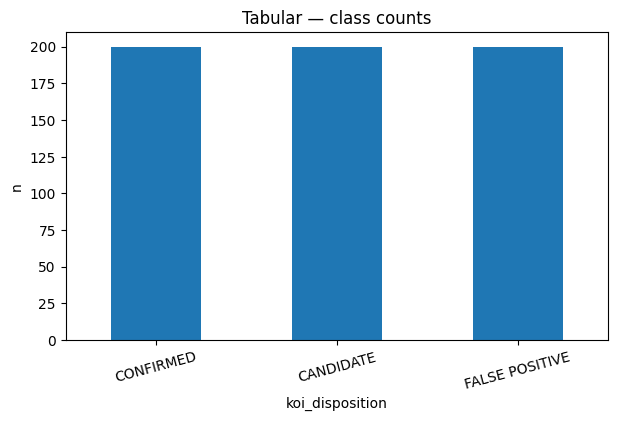

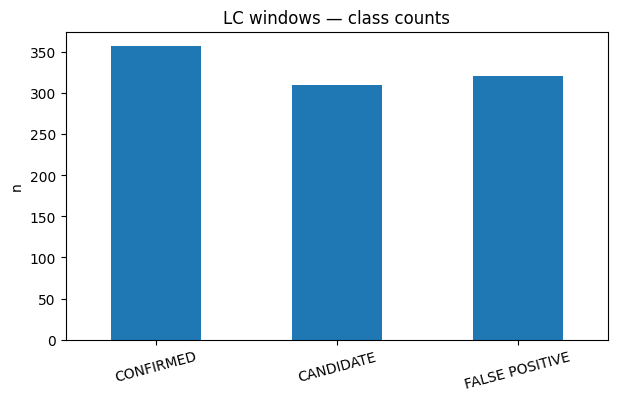

In [21]:
tab_cols = ["koi_period","koi_duration","koi_depth","koi_model_snr",
            "koi_fpflag_nt","koi_fpflag_ss","koi_fpflag_co","koi_fpflag_ec"]

features_tab = sample_tab_df.copy().reset_index(drop=True)
y_tab = features_tab["koi_disposition"].map(label_map).to_numpy(dtype=np.int64)

for c in tab_cols:
    features_tab[c] = pd.to_numeric(features_tab[c], errors="coerce")
features_tab[tab_cols] = features_tab[tab_cols].fillna(0.0).astype(np.float32)

scaler = StandardScaler()
X_tab = scaler.fit_transform(features_tab[tab_cols].to_numpy(dtype=np.float32))

print("Tabular X:", X_tab.shape, "y:", y_tab.shape)
print(features_tab["koi_disposition"].value_counts())

# Quick class balance visuals
ax = features_tab["koi_disposition"].value_counts().reindex(["CONFIRMED","CANDIDATE","FALSE POSITIVE"]).plot(kind="bar")
ax.set_title("Tabular — class counts"); ax.set_ylabel("n"); plt.xticks(rotation=15); plt.show()

ax2 = pd.Series(y_lc).map({v:k for k,v in label_map.items()}).value_counts() \
        .reindex(["CONFIRMED","CANDIDATE","FALSE POSITIVE"]).plot(kind="bar")
ax2.set_title("LC windows — class counts"); ax2.set_ylabel("n"); plt.xticks(rotation=15); plt.show()

In [86]:
X_lc_cnn = X_lc[..., np.newaxis]

scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)

indices = np.arange(len(y_tab))
train_idx, test_idx = train_test_split(indices, test_size=0.25, stratify=y_tab, random_state=42)

Xtr_lc_cnn = X_lc_cnn[train_idx]
Xte_lc_cnn = X_lc_cnn[test_idx]
Xtr_tab_scaled = X_tab_scaled[train_idx]
Xte_tab_scaled = X_tab_scaled[test_idx]
ytr = y_tab[train_idx]
yte = y_tab[test_idx]

# One-hot for CNN training
ytr_cat = to_categorical(ytr, num_classes=3)
yte_cat = to_categorical(yte, num_classes=3)

In [87]:
# === DNN Branch for Tabular Features ===
input_tab = Input(shape=(X_tab_scaled.shape[1],), name='input_tab')

# Deep layers for tabular data
t = Dense(256, activation='relu')(input_tab)
t = BatchNormalization()(t)
t = Dropout(0.5)(t)

t = Dense(128, activation='relu')(t)
t = BatchNormalization()(t)
t = Dropout(0.4)(t)

tab_embedding = Dense(64, activation='relu', name='tab_embedding')(t)
tab_embedding = Dropout(0.3)(tab_embedding)

# === Fusion Layer ===
# Concatenate both branches
fusion = Concatenate(name='fusion')([cnn_embedding, tab_embedding])

# Final dense layers
f = Dense(256, activation='relu')(fusion)
f = BatchNormalization()(f)
f = Dropout(0.5)(f)

f = Dense(128, activation='relu')(f)
f = BatchNormalization()(f)
f = Dropout(0.4)(f)

In [88]:
combined_embedding = Dense(128, activation='relu', name='combined_embedding')(f)

output = Dense(3, activation='softmax', name='output')(combined_embedding)

hybrid_model = Model(inputs=[input_lc, input_tab], outputs=output)
hybrid_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_lc            │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_203 (Conv1D) │ (None, 200, 64)   │        384 │ input_lc[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mish_42 (Mish)      │ (None, 200, 64)   │          0 │ conv1d_203[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 100, 64)   │          0 │ mish_42[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_204 (Conv1D) │ (None, 100, 128)  │     24,704 │ max_pooling1d_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_204[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mish_43 (Mish)      │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_205 (Conv1D) │ (None, 100, 128)  │     49,280 │ mish_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_205[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_206 (Conv1D) │ (None, 100, 128)  │      8,320 │ max_pooling1d_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_206[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mish_44 (Mish)      │ (None, 100, 128)  │          0 │ add_55[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 50, 128)   │          0 │ mish_44[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_207 (Conv1D) │ (None, 50, 256)   │     98,560 │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ conv1d_207[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mish_45 (Mish)      │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_208 (Conv1D) │ (None, 50, 256)   │    196,864 │ mish_45[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ conv1d_208[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_209 (Conv1D) │ (None, 50, 256)   │     33,024 │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 50, 256)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_209[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,172,611 (8.29 MB)

 Trainable params: 2,166,979 (8.27 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [89]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_hybrid_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [90]:
print("\n=== Training Hybrid CNN-DNN Model ===")
history_hybrid = hybrid_model.fit(
    [Xtr_lc_cnn, Xtr_tab_scaled], ytr_cat,
    validation_data=([Xte_lc_cnn, Xte_tab_scaled], yte_cat),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)


=== Training Hybrid CNN-DNN Model ===
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3746 - loss: 1.3757
Epoch 1: val_accuracy improved from -inf to 0.34667, saving model to best_hybrid_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.3757 - loss: 1.3728 - val_accuracy: 0.3467 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 2/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4946 - loss: 1.0223
Epoch 2: val_accuracy improved from 0.34667 to 0.35333, saving model to best_hybrid_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4952 - loss: 1.0206 - val_accuracy: 0.3533 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 3/100
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6279 - loss: 0.8261
Epoch 3: val_accuracy improved from 0.35333 to 0.38667, saving model to best_hybrid_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6270 - loss: 0.8259 - val_accuracy: 0.3867 - val_loss: 0.9514 - learning_rate: 0.0

In [91]:
embedding_model = Model(
    inputs=hybrid_model.input,
    outputs=hybrid_model.get_layer('combined_embedding').output
)

Xtr_hybrid_emb = embedding_model.predict([Xtr_lc_cnn, Xtr_tab_scaled], verbose=0)
Xte_hybrid_emb = embedding_model.predict([Xte_lc_cnn, Xte_tab_scaled], verbose=0)

# Combine original tabular features with deep embeddings
Xtr_comb = np.hstack([Xtr_tab_scaled, Xtr_hybrid_emb])
Xte_comb = np.hstack([Xte_tab_scaled, Xte_hybrid_emb])

print(f"Combined features shape: {Xtr_comb.shape}")

Combined features shape: (450, 136)



Test Accuracy: 0.6800

Classification Report:
              precision    recall  f1-score   support

   FALSE POS       0.94      1.00      0.97        50
   CANDIDATE       0.80      0.08      0.15        50
   CONFIRMED       0.52      0.96      0.68        50

    accuracy                           0.68       150
   macro avg       0.76      0.68      0.60       150
weighted avg       0.76      0.68      0.60       150


Confusion Matrix:
[[50  0  0]
 [ 2  4 44]
 [ 1  1 48]]


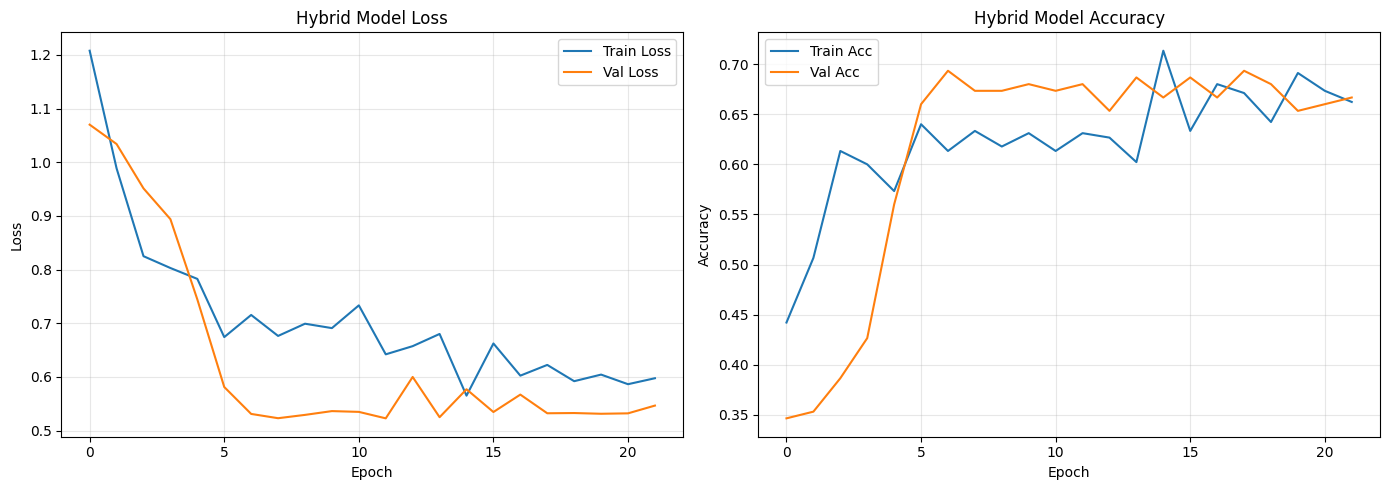

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === Predict on Test Set ===
y_pred_prob = hybrid_model.predict([Xte_lc_cnn, Xte_tab_scaled], verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(yte_cat, axis=1)  # one-hot to label

# === Accuracy and Classification Report ===
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["FALSE POS", "CANDIDATE", "CONFIRMED"]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# === Plot Training History ===
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Loss
axes[0].plot(history_hybrid.history['loss'], label='Train Loss')
axes[0].plot(history_hybrid.history['val_loss'], label='Val Loss')
axes[0].set_title('Hybrid Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_hybrid.history['accuracy'], label='Train Acc')
axes[1].plot(history_hybrid.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Hybrid Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [99]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    early_stopping_rounds=10
)

xgb_model.fit(
    Xtr_comb, ytr,
    eval_set=[(Xtr_comb, ytr), (Xte_comb, yte)],
    verbose=True
)

print(f"\nBest iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score:.4f}")

[0]	validation_0-mlogloss:1.04283	validation_1-mlogloss:1.04882
[1]	validation_0-mlogloss:0.99173	validation_1-mlogloss:1.00267
[2]	validation_0-mlogloss:0.94937	validation_1-mlogloss:0.96668
[3]	validation_0-mlogloss:0.90422	validation_1-mlogloss:0.92642
[4]	validation_0-mlogloss:0.86554	validation_1-mlogloss:0.89354
[5]	validation_0-mlogloss:0.82663	validation_1-mlogloss:0.85788
[6]	validation_0-mlogloss:0.79048	validation_1-mlogloss:0.82471
[7]	validation_0-mlogloss:0.75700	validation_1-mlogloss:0.79500
[8]	validation_0-mlogloss:0.72673	validation_1-mlogloss:0.76797
[9]	validation_0-mlogloss:0.70105	validation_1-mlogloss:0.74681
[10]	validation_0-mlogloss:0.67352	validation_1-mlogloss:0.72236
[11]	validation_0-mlogloss:0.64721	validation_1-mlogloss:0.70017
[12]	validation_0-mlogloss:0.62138	validation_1-mlogloss:0.67820
[13]	validation_0-mlogloss:0.59764	validation_1-mlogloss:0.65975
[14]	validation_0-mlogloss:0.57554	validation_1-mlogloss:0.64420
[15]	validation_0-mlogloss:0.55622	

In [100]:
print("=== EVALUATION RESULTS ===")

# Hybrid Model Evaluation
y_pred_hybrid = hybrid_model.predict([Xte_lc_cnn, Xte_tab_scaled], verbose=0)
y_pred_hybrid_classes = np.argmax(y_pred_hybrid, axis=1)
acc_hybrid = accuracy_score(yte, y_pred_hybrid_classes)

print(f"\n--- Hybrid CNN-DNN Model ---")
print(f"Test Accuracy: {acc_hybrid:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(yte, y_pred_hybrid_classes))
print("\nClassification Report:")
print(classification_report(yte, y_pred_hybrid_classes, 
                          target_names=["FALSE POS", "CANDIDATE", "CONFIRMED"]))

=== EVALUATION RESULTS ===

--- Hybrid CNN-DNN Model ---
Test Accuracy: 0.6800

Confusion Matrix:
[[50  0  0]
 [ 2  4 44]
 [ 1  1 48]]

Classification Report:
              precision    recall  f1-score   support

   FALSE POS       0.94      1.00      0.97        50
   CANDIDATE       0.80      0.08      0.15        50
   CONFIRMED       0.52      0.96      0.68        50

    accuracy                           0.68       150
   macro avg       0.76      0.68      0.60       150
weighted avg       0.76      0.68      0.60       150



In [101]:
# XGBoost Ensemble Evaluation
y_pred_xgb = xgb_model.predict(Xte_comb)
acc_xgb = accuracy_score(yte, y_pred_xgb)

print(f"\n--- XGBoost Ensemble ---")
print(f"Test Accuracy: {acc_xgb:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(yte, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(yte, y_pred_xgb, 
                          target_names=["FALSE POS", "CANDIDATE", "CONFIRMED"]))


--- XGBoost Ensemble ---
Test Accuracy: 0.8733

Confusion Matrix:
[[50  0  0]
 [ 2 44  4]
 [ 1 12 37]]

Classification Report:
              precision    recall  f1-score   support

   FALSE POS       0.94      1.00      0.97        50
   CANDIDATE       0.79      0.88      0.83        50
   CONFIRMED       0.90      0.74      0.81        50

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



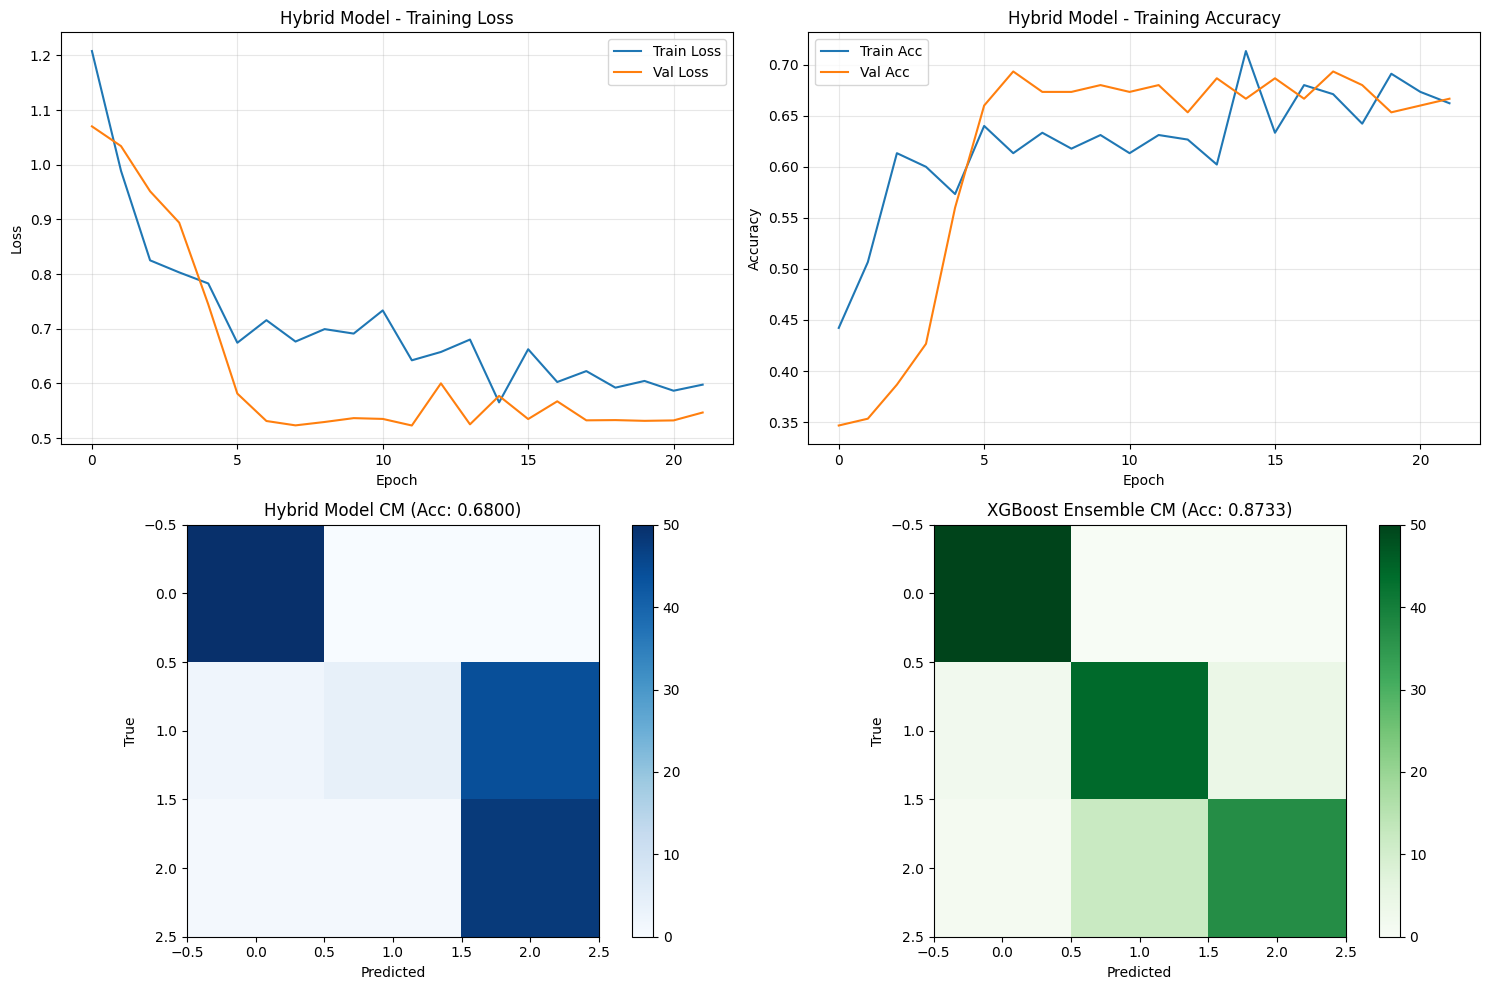

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_hybrid.history['loss'], label='Train Loss')
axes[0, 0].plot(history_hybrid.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Hybrid Model - Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_hybrid.history['accuracy'], label='Train Acc')
axes[0, 1].plot(history_hybrid.history['val_accuracy'], label='Val Acc')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Hybrid Model - Training Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

cm_hybrid = confusion_matrix(yte, y_pred_hybrid_classes)
cm_xgb = confusion_matrix(yte, y_pred_xgb)

im1 = axes[1, 0].imshow(cm_hybrid, cmap='Blues')
axes[1, 0].set_title(f'Hybrid Model CM (Acc: {acc_hybrid:.4f})')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(cm_xgb, cmap='Greens')
axes[1, 1].set_title(f'XGBoost Ensemble CM (Acc: {acc_xgb:.4f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

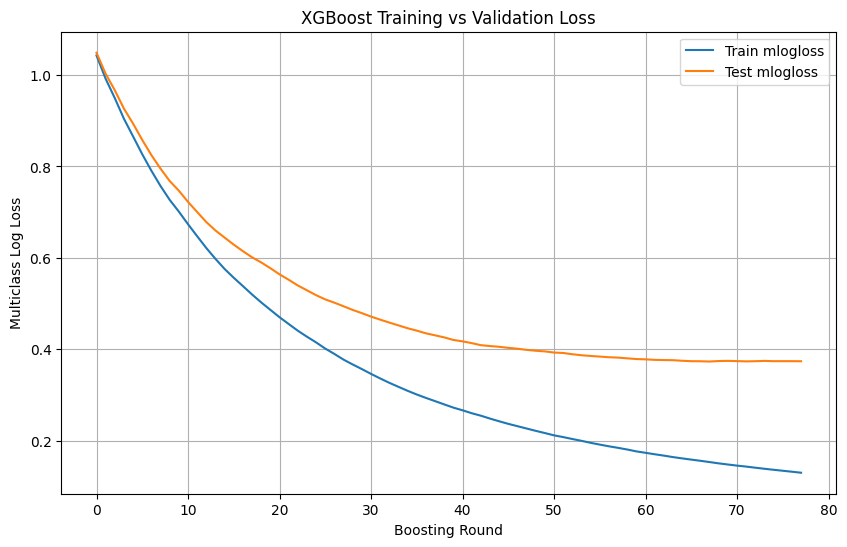

In [105]:
results = xgb_model.evals_result() 
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train mlogloss')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test mlogloss')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('Multiclass Log Loss')
ax.set_title('XGBoost Training vs Validation Loss')
ax.legend()
ax.grid(True)
plt.show()

In [106]:
print("\n=== Training Complete ===")
print(f"Best Hybrid Model saved as: best_hybrid_model.h5")
print(f"Final Hybrid Model Accuracy: {acc_hybrid:.4f}")
print(f"Final XGBoost Ensemble Accuracy: {acc_xgb:.4f}")


=== Training Complete ===
Best Hybrid Model saved as: best_hybrid_model.h5
Final Hybrid Model Accuracy: 0.6800
Final XGBoost Ensemble Accuracy: 0.8733


In [109]:
# Save as binary
xgb_model.save_model("/kaggle/working/xgb_model.json")  
xgb_model.save_model("/kaggle/working/xgb_model.bin")  

In [110]:
import pickle

# Save
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

# Load
with open("xgb_model.pkl", "rb") as f:
    loaded_xgb = pickle.load(f)